# LEO Link Budget using Stage Components

Compute forward (ground-to-space) and return (space-to-ground) C/N₀ and link margin for LEO altitudes from 2 000 km down to 500 km.

This notebook follows the object-oriented approach using `Stage` components as per the `link_budget` rule.

**Parameters:**
- Ground Station: 3.7 m dish (70% efficiency)
- Satellite Antenna: 0 dBi fixed gain
- Frequencies: S-Band Near Space (Forward: 2100 MHz, Return: 2250 MHz)
- Ground Tx Power: 50 W
- Satellite Tx Power: 20 W
- Data Rates: Forward 1 Mbps, Return 10 Mbps (using simple BPSK/QPSK)
- Required Eb/N0: 5 dB (example)
- Implementation Loss: 1 dB (example)

In [1]:
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from spacelink.components.transmitter import Transmitter
from spacelink.components.antenna import Dish, FixedGain
from spacelink.components.stage import (
    TransmitAntenna,
    ReceiveAntenna,
    Path,
    GainBlock,
    Attenuator,
)
from spacelink.components.demodulator import Demodulator
from spacelink.components.mode import DataMode
from spacelink.core.units import Decibels, to_dB
from spacelink.core.modcod import ErrorRate  # Assuming we need ErrorRate for DataMode
from spacelink.core.noise import T0

In [2]:
# --- System Parameters ---

# Altitudes
distances = np.linspace(2000, 500, 8) * u.km

# Frequencies (Near Space S-Band)
forward_freq = 2100 * u.MHz
return_freq = 2250 * u.MHz

# Ground Station
gs_dish = Dish(
    diameter=3.7 * u.m,
    efficiency=0.7 * u.dimensionless,
    noise_temperature=50 * u.K,
    return_loss=20.0 * u.dB,
    axial_ratio=3.0 * u.dB,
)
sat_antenna = FixedGain(
    gain=0 * u.dB,
    axial_ratio=3.0 * u.dB,
    noise_temperature=150 * u.K,
    return_loss=20.0 * u.dB,
)

forward_symbol_rate = 9600 * u.Hz
return_symbol_rate = 2 * u.MHz

distance = 2000 * u.km

# BPSK w/ concatenated Voyager code
data_mode = DataMode(
    coding_scheme="CC(7,1/2) RS(255,223) I=5", bits_per_symbol=1 * u.dimensionless
)

In [3]:
gs_transmitter = Transmitter(power=20 * u.W, noise_temperature=290 * u.K)
gs_tx_antenna = TransmitAntenna(antenna=gs_dish)
gs_rx_antenna = ReceiveAntenna(antenna=gs_dish)
gs_cable = Attenuator(attenuation=0.5 * u.dB)
gs_lna = GainBlock(gain_value=20 * u.dB, noise_temperature=100 * u.K)
gs_demodulator = Demodulator(
    carrier_frequency=return_freq, symbol_rate=return_symbol_rate, data_mode=data_mode
)


gs_tx_antenna.input = gs_transmitter


# Satellite Components
sat_transmitter = Transmitter(power=10 * u.W, noise_temperature=290 * u.K)
sat_tx_antenna = TransmitAntenna(antenna=FixedGain(gain=-10 * u.dB))
sat_rx_antenna = ReceiveAntenna(
    antenna=FixedGain(gain=-10 * u.dB, noise_temperature=150 * u.K)
)
sat_demodulator = Demodulator(
    carrier_frequency=forward_freq, symbol_rate=forward_symbol_rate, data_mode=data_mode
)

path = Path(distance=2000 * u.km)
gs_tx_antenna.input = gs_transmitter
path.input = gs_tx_antenna
sat_rx_antenna.input = path
sat_demodulator.input = sat_rx_antenna
forward_margin = sat_demodulator.data_margin

In [4]:
print(f"Forward path loss: {path.loss(forward_freq):0.2f}")
print(f"Forward C/N0: {sat_demodulator.cn0():0.2f}")
print(f"Forward margin: {sat_demodulator.data_margin:0.2f}")

Forward path loss: 164.91 dB
Forward C/N0: 81.48 dB
Forward margin: 42.95 dB


In [5]:
# --- Simulation Loop ---
results = []
for h in distances:
    # Create Path Stage for this altitude
    path = Path(distance=h)

    # --- Forward Link (Ground -> Space) ---
    # Build chain
    gs_tx_antenna.input = gs_transmitter
    path.input = gs_tx_antenna
    sat_rx_antenna.input = path
    sat_demodulator.input = sat_rx_antenna
    forward_margin = sat_demodulator.data_margin

    # --- Return Link (Space -> Ground) ---
    # Build chain
    sat_tx_antenna.input = sat_transmitter
    path.input = sat_tx_antenna  # Reuse path, just change input
    gs_rx_antenna.input = path
    gs_demodulator.input = gs_rx_antenna
    # Calculate Margin (using helper function)
    return_margin = gs_demodulator.data_margin
    results.append(
        {
            "Altitude (km)": h.to(u.km).value,
            "Forward C/N0 (dB-Hz)": sat_demodulator.cn0().value,
            "Return C/N0 (dB-Hz)": gs_demodulator.cn0().value,
            "Forward Margin (dB)": forward_margin.value,
            "Return Margin (dB)": return_margin.value,
        }
    )

# Create DataFrame
df_results = pd.DataFrame(results)
df_results.set_index("Altitude (km)", inplace=True)
df_results

,Forward C/N0 (dB-Hz),Return C/N0 (dB-Hz),Forward Margin (dB),Return Margin (dB)
Altitude (km),,,,
2000.000000,31.925486,83.237515,42.946544,21.519868
1785.714286,32.909846,84.221876,43.930904,22.504229
1571.428571,34.020193,85.332222,45.041251,23.614575
1357.142857,35.293574,86.605604,46.314632,24.887957
1142.857143,36.786247,88.098276,47.807304,26.380629
928.571429,38.589779,89.901809,49.610837,28.184162
714.285714,40.868646,92.180676,51.889704,30.463029
500.000000,43.966685,95.278715,54.987743,33.561068


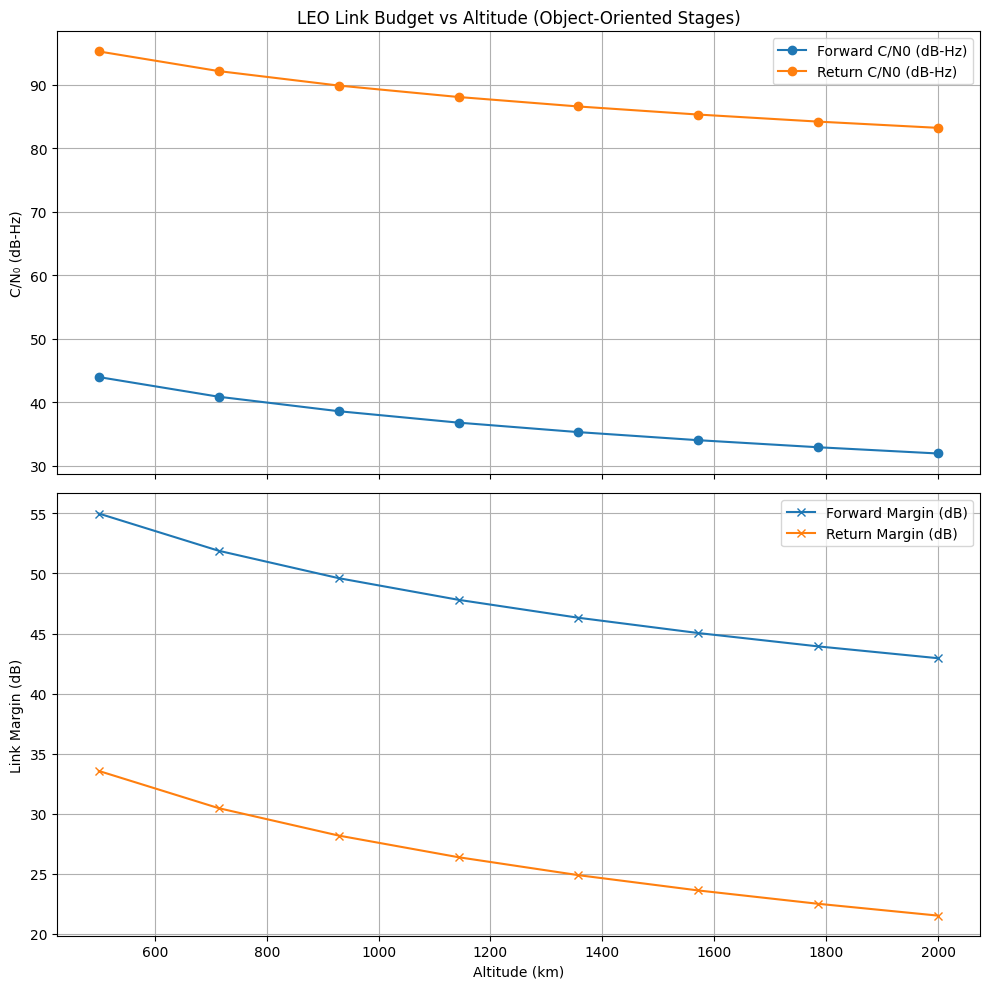

In [6]:
# --- Plot Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# C/N0 Plot
df_results[["Forward C/N0 (dB-Hz)", "Return C/N0 (dB-Hz)"]].plot(ax=ax1, marker="o")
ax1.set_ylabel("C/N₀ (dB-Hz)")
ax1.set_title("LEO Link Budget vs Altitude (Object-Oriented Stages)")
ax1.grid(True)
ax1.legend()

# Margin Plot
df_results[["Forward Margin (dB)", "Return Margin (dB)"]].plot(ax=ax2, marker="x")
ax2.set_xlabel("Altitude (km)")
ax2.set_ylabel("Link Margin (dB)")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()